In [84]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import matplotlib.pyplot as plt

In [102]:
# Import journey and price data

prot_journeys = pickle.load(open('Data/prototype_week','rb'))
test_journeys = pickle.load(open('Data/test_week','rb'))
BAU_profile = pickle.load(open('Data/BAU_profile','rb'))
day_journeys = f.get_daily_data(prot_journeys, gv.DAY)
day_profile = f.create_daily_schedule(BAU_profile, gv.DAY)

In [103]:
day_journeys.loc[0,'End_Time_of_Route'] = dt.datetime(2019,2,10,17,0,21)
day_journeys.head()

,End_Time_of_Route,Energy_Required,Start_next_route
Vehicle_ID,,,
0,2019-02-10 17:00:21,26.8191,2019-02-11 05:15:00
1,2019-02-10 12:58:59,31.331,2019-02-11 05:15:00
2,2019-02-10 12:35:00,26.5713,2019-02-11 05:15:00
3,2019-02-10 13:14:00,23.5697,2019-02-11 05:15:00
4,2019-02-10 11:05:59,29.2441,2019-02-11 05:15:00


In [104]:
day_profile.head()

Output_BAU  unit_rate_excl_vat
from                Vehicle                                
2019-02-10 11:00:00 0               0.0               12.26
                    1               0.0               12.26
                    2               0.0               12.26
                    3               0.0               12.26
                    4               0.0               12.26

In [105]:
# Define output variable
outputs = LpVariable.dicts("output",
((period, vehicle) for period, vehicle in day_profile.index),
lowBound = 0,
upBound = 3.5,
cat = "Continuous"
)

In [106]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Multiple_vehicle_scheduling",LpMinimize)

# Add costs to objective function

prob += lpSum(
    [day_profile.loc[(period, vehicle), 'unit_rate_excl_vat'] * outputs[period, vehicle] for period, vehicle in day_profile.index]
    ), "Total Charging costs"


In [107]:
# Final SOC constraint
time_period = day_profile.index.get_level_values(0)
vehicles = day_journeys.index

for vehicle in vehicles:
    prob += lpSum(
        [outputs[period, vehicle] for period in time_period])/gv.NUM_VEHICLES == day_journeys.loc[vehicle, 'Energy_Required'] / gv.CHARGER_EFF

# Output after/before departure/arrival is 0

for period, vehicle in day_profile.index:
    arrival = day_journeys.loc[vehicle, "End_Time_of_Route"]
    departure = day_journeys.loc[vehicle, "Start_next_route"]
    if period < arrival:
        prob += outputs[(period, vehicle)] == 0
    elif period + dt.timedelta(minutes=30) > departure:
        prob += outputs[period, vehicle] == 0

# Max capacity constraint
for period in time_period:
    prob += lpSum(
        [outputs[period, vehicle] for vehicle in vehicles]) <= gv.SITE_CAPACITY

In [108]:
prob

00:00'),_2) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_3) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_4) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_5) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_6) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_7) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_8) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:00:00'),_9) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_0) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_1) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_2) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_3) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_4) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_5) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_6) <= 3.5 Continuous
output_(Timestamp('2019_02_10_19:30:00'),_7) <= 3.5 Continuous
output_(Timestamp('2019_0

In [109]:
# The problem data is written to an .lp file
prob.writeLP("Models/multi_vehicle.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Get output variables
charge_output = []

for period, vehicle in outputs:
    var_output = {
        'from': period,
        'Vehicle': vehicle,
        'Output_Opt': outputs[(period, vehicle)].varValue
    }
    charge_output.append(var_output)

output_df = pd.DataFrame.from_records(charge_output).sort_values(['from','Vehicle'])
output_df.set_index(['from', 'Vehicle'], inplace=True)
print('Cost:', value(prob.objective))
day_profile = day_profile.merge(
    output_df,
    how='left',
    left_index=True,
    right_index=True,
    )


Status: Optimal
Cost: 2590.3612090363995


In [110]:
# Get information columns

day_profile['Charge_Delivered_Opt'] = day_profile['Output_Opt'] * gv.CHARGER_EFF
day_profile['Charge_Delivered_BAU'] = day_profile['Output_BAU'] * gv.CHARGER_EFF
day_profile['Electricity_Cost_Opt'] = day_profile['Output_Opt'] * day_profile['unit_rate_excl_vat']
day_profile['Electricity_Cost_BAU'] = day_profile['Output_BAU'] * day_profile['unit_rate_excl_vat']
for vehicle in vehicles:
    opt_soc = round(gv.BATTERY_CAPACITY - day_journeys.loc[vehicle,'Energy_Required'] + day_profile.loc[(slice(None),vehicle),'Charge_Delivered_Opt'].cumsum(),3)
    day_profile.loc[(slice(None),vehicle),'SOC_Opt'] = opt_soc
    opt_BAU = round(gv.BATTERY_CAPACITY - day_journeys.loc[vehicle,'Energy_Required'] + day_profile.loc[(slice(None),vehicle),'Charge_Delivered_BAU'].cumsum(),3)
    day_profile.loc[(slice(None),vehicle),'SOC_BAU'] = opt_BAU

In [111]:
day_profile.head()

Output_BAU  unit_rate_excl_vat  Output_Opt  \
from                Vehicle                                               
2019-02-10 11:00:00 0               0.0               12.26         0.0   
                    1               0.0               12.26         0.0   
                    2               0.0               12.26         0.0   
                    3               0.0               12.26         0.0   
                    4               0.0               12.26         0.0   

                             Charge_Delivered_Opt  Charge_Delivered_BAU  \
from                Vehicle                                               
2019-02-10 11:00:00 0                         0.0                   0.0   
                    1                         0.0                   0.0   
                    2                         0.0                   0.0   
                    3                         0.0                   0.0   
                    4                         0.0                   0.0   

                             Electricity_Cost_Opt  Electricity_Cost_BAU  \
from                Vehicle                                               
2019-02-10 11:00:00 0                         0.0                   0.0   
                    1                         0.0                   0.0   
                    2                         0.0                   0.0   
                    3                         0.0                   0.0   
                    4                         0.0                   0.0   

                             SOC_Opt  SOC_BAU  
from                Vehicle                    
2019-02-10 11:00:00 0         48.181   48.181  
                    1         43.669   43.669  
                    2         48.429   48.429  
                    3         51.430   51.430  
                    4         45.756   45.756

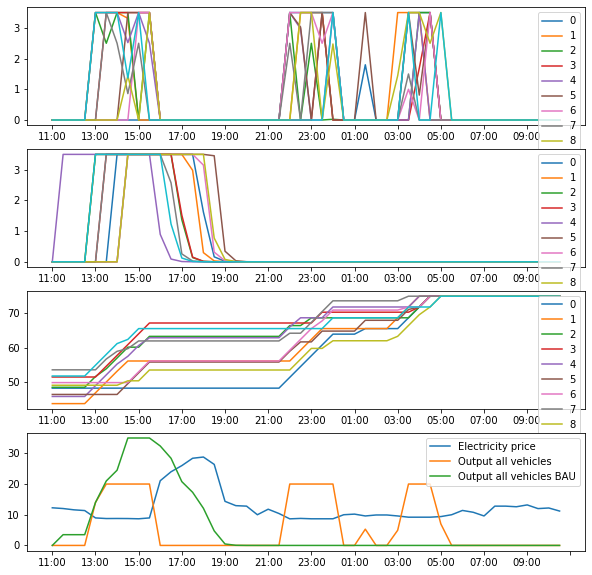

In [96]:
# Figures #FIXME set as two columns of figures and add SOC of BAU

fig, axs = plt.subplots(4,figsize=(10,10))
x = day_profile.unstack().index.strftime('%H:%M')

axs[0].plot(x, day_profile['Output_Optimiser'].unstack())
axs[1].plot(x, day_profile['Output_BAU'].unstack())

axs[3].plot(x, day_profile.loc[(slice(None),0),'unit_rate_excl_vat'], label = 'Electricity price')
axs[3].plot(x, day_profile['Output_Optimiser'].groupby(level=0).sum(), label='Output all vehicles')
axs[3].plot(x, day_profile['Output_BAU'].groupby(level=0).sum(), label='Output all vehicles BAU')

axs[2].plot(x, day_profile['SOC_Opt'].unstack())

axs[0].xaxis.set_major_locator(plt.MaxNLocator(13))
axs[0].legend(vehicles)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(13))
axs[1].legend(vehicles)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(13))
axs[3].legend()
axs[2].xaxis.set_major_locator(plt.MaxNLocator(13))
axs[2].legend(vehicles)
fig.show()
fig.savefig('Data/multi_veh.jpg')

In [119]:
# Summary Table: Energy Use, peak power draw and cost per vehicle (optimiser and benchmark)
# FIXME use .agg() to simplyfy this

day_journeys['Energy_Use_Opt'] = day_profile['Output_Opt'].groupby(level=1).sum()
day_journeys['Electricity_Cost_Opt'] = day_profile['Electricity_Cost_Opt'].groupby(level=1).sum()
day_journeys['Electricity_Cost_BAU'] = day_profile['Electricity_Cost_BAU'].groupby(level=1).sum()
day_journeys['Peak_Output_Opt'] = day_profile['Output_Opt'].groupby(level=1).max()
day_journeys['Peak_Output_BAU'] = day_profile['Output_BAU'].groupby(level=1).max()

day_journeys.head()


,End_Time_of_Route,Energy_Required,Start_next_route,Energy_Use_Opt,Electricity_Cost_Opt,Electricity_Cost_BAU,Peak_output,Peak_Output_Opt,Peak_Output_BAU
Vehicle_ID,,,,,,,,,
0,2019-02-10 17:00:21,26.8191,2019-02-11 05:15:00,29.799000,266.120400,522.470246,3.5,3.5,3.5
1,2019-02-10 12:58:59,31.331,2019-02-11 05:15:00,34.812222,311.325066,528.009750,3.5,3.5,3.5
2,2019-02-10 12:35:00,26.5713,2019-02-11 05:15:00,29.523630,262.625105,382.910623,3.5,3.5,3.5
3,2019-02-10 13:14:00,23.5697,2019-02-11 05:15:00,26.188519,231.904370,355.877370,3.5,3.5,3.5
4,2019-02-10 11:05:59,29.2441,2019-02-11 05:15:00,32.493489,286.661856,328.835102,3.5,3.5,3.5


In [ ]:
# TODO: Create Summary per time and ovreall

In [ ]:
output_df['Electricity_cost'] = output_df['']

In [ ]:
# TODO: Output Logs

# Global variables
# Output_df
# Plot
# Summary table
# Notes